In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import AgglomerativeClustering
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

Using TensorFlow backend.


In [2]:
#x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
#y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
#x = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
#y = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
#x = np.array([0, 0, 1, 2, 1, 0, 1, 0, 0])
#y = np.array([0, 1, 2, 0, 0, 0, 0, 0, 0])
x = np.array([1, 2, 3, 2, 2.13, 1])
y = np.array([1, 1, 2, 2, 2.42, 3, 2, 1])
euclidean_norm = lambda x, y: np.abs(x - y)
def dtw(x, y, func):
    cost_matrix = np.empty((len(y), len(x)))
    cost_matrix.fill(np.nan)
    for i in range(len(y)):
        for j in range(len(x)):
            cost_matrix[i, j] = func(x[j], y[i])
    acc_cost_matrix = np.empty((len(y), len(x)))
    acc_cost_matrix.fill(np.nan)
    acc_cost_matrix[0, 0] = cost_matrix[0, 0]
    for i in range(1, len(y)):
        acc_cost_matrix[i, 0] = acc_cost_matrix[i-1, 0] +\
                                cost_matrix[i, 0]
    for j in range(1, len(x)):
        acc_cost_matrix[0, j] = acc_cost_matrix[0, j-1] +\
                                cost_matrix[0, j]
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            acc_cost_matrix[i, j] = cost_matrix[i, j] + \
                                    min(acc_cost_matrix[i-1, j],
                                        acc_cost_matrix[i, j-1],
                                        acc_cost_matrix[i-1, j-1])
    path_x = []
    path_y = []
    x_idx = len(x)-1
    y_idx = len(y)-1
    path_x.append(x_idx)
    path_y.append(y_idx)
    while y_idx != 0 or x_idx != 0:
        if y_idx >= 1 and x_idx >= 1:
            up = acc_cost_matrix[y_idx-1, x_idx]
            diag = acc_cost_matrix[y_idx-1, x_idx-1]
            acro = acc_cost_matrix[y_idx, x_idx-1]
            if min(up, diag, acro) == diag:
                x_idx -= 1
                y_idx -= 1
            elif min(up, diag, acro) == up:
                y_idx -= 1
            elif min(up, diag, acro) == acro:
                x_idx -= 1     
        elif y_idx == 0:
            x_idx -= 1
        elif x_idx == 0:
            y_idx -= 1
        path_x.append(x_idx)
        path_y.append(y_idx)
    path_x = path_x[::-1]
    path_y = path_y[::-1]
    
    distance = acc_cost_matrix[len(y)-1, len(x)-1]
    path = np.array([path_x, path_y])
    return distance, cost_matrix, acc_cost_matrix, path
distance, cost_matrix, acc_cost_matrix, path = dtw(x, y, euclidean_norm)
print(path[0])
print(path[1])

[0 0 1 1 1 2 3 4 5]
[0 1 2 3 4 5 6 6 7]


(2, 9)
0.5499999999999998
[[0.   1.   3.   4.   5.13 5.13]
 [0.   1.   3.   4.   5.13 5.13]
 [1.   0.   1.   1.   1.13 2.13]
 [2.   0.   1.   1.   1.13 2.13]
 [3.42 0.42 0.58 1.   1.29 2.55]
 [5.42 1.42 0.42 1.42 1.87 3.29]
 [6.42 1.42 1.42 0.42 0.55 1.55]
 [6.42 2.42 3.42 1.42 1.55 0.55]]


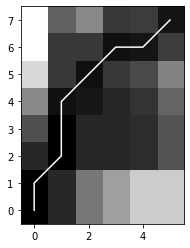

In [3]:
print(path.shape)
print(distance)
print(acc_cost_matrix)
pyplot.imshow(acc_cost_matrix, origin='lower', cmap='gray', interpolation='nearest')
pyplot.plot(path[0], path[1], 'w')
pyplot.show()

In [4]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 
                       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                       'TRUE_TCHDL', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
print(VIEW_sub_df.shape)
print(VIEW_sub_df.isnull().sum())


(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')
(2099160, 33)
STUDENT_INDEX_MASTER          0
DATE                          0
QUARTERS                      0
AGE                           0
ETHNICITY                     0
SEX                      

In [5]:
# Count size of ethnicity groups
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'D'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'F'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'G'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H'].shape[0]//28)

3611
44538
6552
1243
7390
50
2358
9228


In [6]:
# Combine D, F and G
VIEW_sub_A_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A']
VIEW_sub_B_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B']
VIEW_sub_C_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C']
VIEW_sub_D_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY.isin(['D', 'F', 'G'])] # MELAA, Other and Other_Asian
VIEW_sub_E_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E']
VIEW_sub_H_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H']
print(VIEW_sub_A_df.shape[0]//28)
print(VIEW_sub_B_df.shape[0]//28)
print(VIEW_sub_C_df.shape[0]//28)
print(VIEW_sub_D_df.shape[0]//28)
print(VIEW_sub_E_df.shape[0]//28)
print(VIEW_sub_H_df.shape[0]//28)

3611
44538
6552
3651
7390
9228


In [7]:
# random sampling unique ID 
# to control ethn imbalance
ethn_A_list = VIEW_sub_A_df.STUDENT_INDEX_MASTER.unique()
ethn_B_list = VIEW_sub_B_df.STUDENT_INDEX_MASTER.unique()
ethn_C_list = VIEW_sub_C_df.STUDENT_INDEX_MASTER.unique()
ethn_D_list = VIEW_sub_D_df.STUDENT_INDEX_MASTER.unique()
ethn_E_list = VIEW_sub_E_df.STUDENT_INDEX_MASTER.unique()
ethn_H_list = VIEW_sub_H_df.STUDENT_INDEX_MASTER.unique()
ethn_A_sample = list(np.random.choice(ethn_A_list, 3500, replace=False))
ethn_B_sample = list(np.random.choice(ethn_B_list, 5000, replace=False)) # over sample Europeans
ethn_C_sample = list(np.random.choice(ethn_C_list, 3500, replace=False)) # to make a data of 
ethn_D_sample = list(np.random.choice(ethn_D_list, 3500, replace=False)) # 20,000 individuals
ethn_E_sample = list(np.random.choice(ethn_E_list, 3500, replace=False)) # 3335 all others 3333
ethn_H_sample = list(np.random.choice(ethn_H_list, 3500, replace=False))
print(VIEW_sub_df.shape)
ethn_sample = ethn_A_sample + ethn_B_sample + ethn_C_sample + \
              ethn_D_sample + ethn_E_sample + ethn_H_sample
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ethn_sample)]
print(VIEW_sub_df.shape)

(2099160, 33)
(630000, 33)


In [8]:
#########################################
# only cluster 20 quarters after PREDICT
#########################################
DTW_quarters = [8,9,10,11,12,13,14,15,16,17,18,19,\
                20,21,22,23,24,25,26,27,]
DTW_VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.QUARTERS.isin(DTW_quarters)]
print(DTW_VIEW_sub_df.shape)
DTW_VIEW_v = DTW_VIEW_sub_df.values
print(DTW_VIEW_v.shape)

(450000, 33)
(450000, 33)


In [9]:
euclidean_norm = lambda x, y: np.abs(x - y)
start_time = time.time()
time_series = []
for i in range(1000):
    time_series.append(DTW_VIEW_v[(i*20):((i+1)*20), 12])

# distance_matrix = np.empty((len(time_series), len(time_series)))
# distance_matrix.fill(np.nan)
distance_list = []

#cost_matrix_list = []       
for i in range(len(time_series)):
    for j in range((i+1), len(time_series)):
        distance, cost_matrix, acc_cost_matrix, path = dtw(time_series[i], 
                                                    time_series[j],
                                                    euclidean_norm)
        distance_list.append(distance)
        #cost_matrix_list.append(acc_cost_matrix)
end_time = time.time()
print("Time took for calculating DTW distance: ", end_time - start_time)
####################################
# fill entire distance matrix from 
# upper tri matrix
####################################
#idx_lower =  np.tril_indices(len(distance_matrix), -1)
#distance_matrix[idx_lower] = distance_matrix.T[idx_lower]


Time took for calculating DTW distance:  507.00625872612


In [15]:
print(np.around(time_series[0].astype(np.double), decimals=2))
print(np.around(time_series[1].astype(np.double), decimals=2))
print(np.around(time_series[2].astype(np.double), decimals=2))
print(np.around(time_series[3].astype(np.double), decimals=2))
print(np.around(time_series[4].astype(np.double), decimals=2))
print(np.around(time_series[5].astype(np.double), decimals=2))
print(np.around(time_series[6].astype(np.double), decimals=2))
print(np.around(time_series[7].astype(np.double), decimals=2))
print(np.around(time_series[8].astype(np.double), decimals=2))
print(np.around(time_series[9].astype(np.double), decimals=2))
#print(np.around(distance_matrix.astype(np.double), decimals=3))
#print(type(distance_matrix[0, 0]))
#print(len(distance_matrix))

[2.49 2.51 2.54 2.56 2.58 2.59 2.55 2.51 2.47 2.44 2.4  2.5  2.61 2.71
 2.82 2.92 3.   3.   3.   3.  ]
[4.34 4.62 4.38 4.14 4.11 4.39 4.67 4.96 5.09 5.08 5.06 5.05 5.03 5.01
 5.   4.98 4.97 4.95 4.94 4.92]
[2.6  2.61 2.61 2.62 2.63 2.63 2.64 2.64 2.65 2.66 2.66 2.67 2.67 2.68
 2.69 2.69 2.7  2.7  2.7  2.7 ]
[2.1  2.1  2.1  2.1  2.2  2.36 2.53 2.69 2.79 2.75 2.71 2.67 2.63 2.61
 2.66 2.7  2.74 2.79 2.83 2.88]
[4.65 4.31 3.97 3.85 4.54 5.   4.91 4.56 7.16 5.57 4.07 4.03 4.03 4.13
 4.19 4.16 4.14 4.11 4.2  4.35]
[5.47 5.5  5.52 5.55 5.58 5.54 5.3  5.05 4.81 4.57 4.33 4.08 3.91 3.97
 4.03 4.09 4.15 4.21 4.27 4.32]
[2.21 2.37 2.54 2.7  2.74 2.6  2.46 2.34 2.25 2.35 2.66 2.73 2.6  2.48
 2.35 2.23 2.1  2.01 2.06 2.1 ]
[4.59 4.58 4.56 4.55 4.54 4.52 4.51 4.67 5.06 5.44 5.83 6.22 5.83 4.74
 3.94 3.4  3.36 3.32 3.29 3.25]
[4.5  4.43 4.35 4.28 4.2  4.13 4.21 4.37 4.53 4.7  4.76 4.66 4.56 4.46
 4.36 4.26 4.24 4.35 4.46 4.57]
[2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.36 2.26 2.16 2.06 1.96 1.95
 2

In [147]:
'''
condense_list = []
len(distance_matrix)
for i in range(len(distance_matrix)):
    for j in range((i+1), len(distance_matrix)):
        condense_list.append(distance_matrix[i, j])
condense_matrix = np.array(condense_list)
print(len(condense_matrix))
print(condense_matrix)
'''

45
[42.50224531  3.00986882  3.56678533 36.71203561 41.05980273  6.53158619
 36.9887314  35.18409747  4.55145244 42.56729498 44.76848795 12.61912013
 16.5674636  47.8243716  14.14106605  6.87461781 49.13622653  3.76286368
 36.77708528 41.12485241  5.743722   37.05378108 35.24914714  6.20486567
 38.97827825 43.32604537  5.72774719 39.25497405 37.45034011  3.73599847
 11.59299652 42.03416191 10.49362049  6.98834996 43.34601683 46.38192903
 14.95952447 11.12392138 47.69378396 42.3108577  40.50622376  4.69840451
 12.75272512 43.62271263 41.81807869]


In [10]:
#####################################
# Agglomerative Clustering
#####################################
#agg = AgglomerativeClustering(n_clusters = 2, 
#                              affinity = "precomputed", 
#                              linkage = 'average')
#fig = pyplot.figure(figsize=(25, 10))
#agg.fit_predict(distance_matrix)
#print(Z)
print(len(distance_list))
condensed_matrix = np.array(distance_list)

499500


Time took for agglomerative clustering:  0.011213064193725586
0.7144987494350151


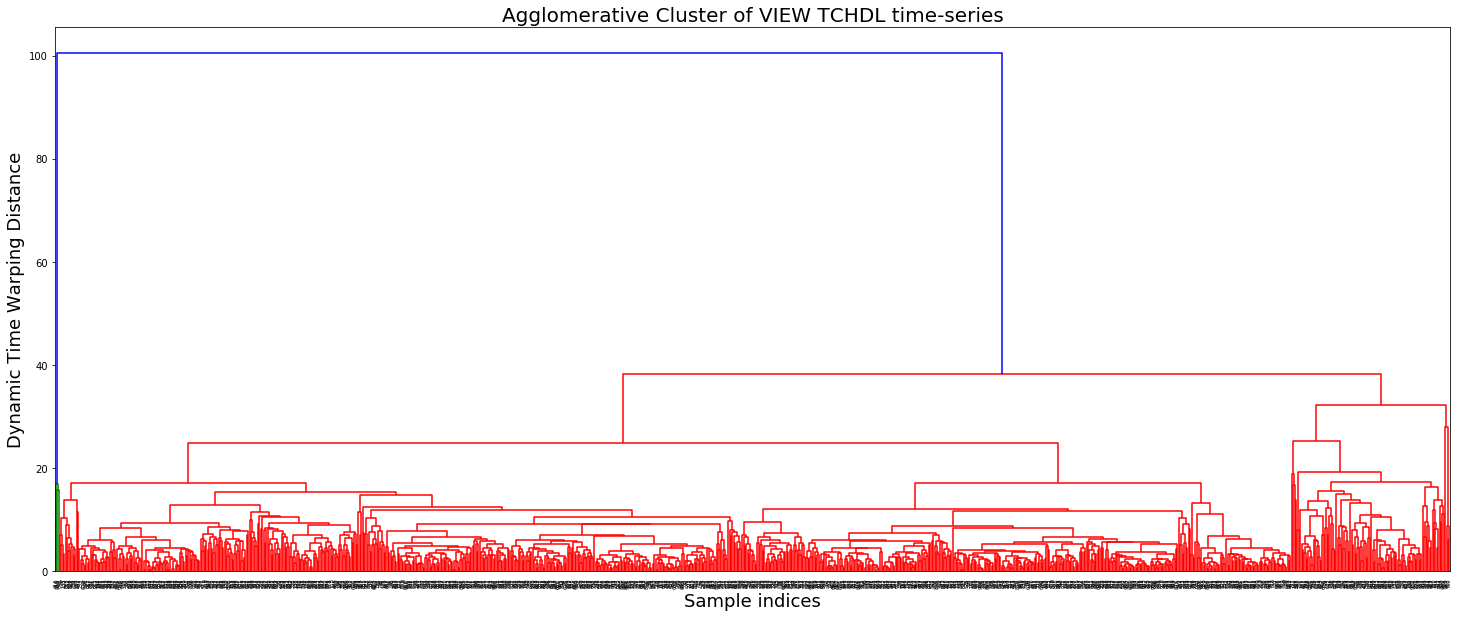

In [108]:
start_time = time.time()
Z = hierarchy.linkage(condensed_matrix, 'average')
end_time = time.time()
print("Time took for agglomerative clustering: ", end_time-start_time)
############################################
# check Cophenetic Correlation Coefficient
# Compares the pairwise distance of samples
# to hierarchical clustering results
# should be close to 1
############################################
c, coph_dist = hierarchy.cophenet(Z, condensed_matrix)

print(c)

fig = pyplot.figure(figsize=(25, 10))
pyplot.title("Agglomerative Cluster of VIEW TCHDL time-series", fontsize=20)
pyplot.xlabel("Sample indices", fontsize=18)
pyplot.ylabel("Dynamic Time Warping Distance", fontsize=18)
dn = hierarchy.dendrogram(Z)
pyplot.show()

In [123]:
cutree = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[5,6,7,8,9,10])
print(cutree[-10:, ])
print(cutree.shape)
print(np.unique(cutree[:, 0]))
print(np.unique(cutree[:, 1]))
print(np.unique(cutree[:, 2]))
print(np.unique(cutree[:, 3]))
print(np.unique(cutree[:, 4]))
print(np.unique(cutree[:, 5]))
print(cutree.shape[0])
print(cutree.shape[1])

[[0 0 0 0 0 0]
 [1 1 2 2 2 2]
 [0 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]]
(1000, 6)
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8 9]
1000
6


In [150]:
import sys
np.set_printoptions(threshold=sys.maxsize, suppress=True)
VIEW_sub_v = VIEW_sub_df.values
print(VIEW_sub_v.shape)  #data contain full 28 quarters
#print(DTW_VIEW_v.shape) # data contain only 20 quarters post PREDICT

start_time = time.time()
clusters5to10 = np.zeros((630000, 6))
clusters5to10.fill(np.nan)
for i in range(cutree.shape[0]):
    for j in range(cutree.shape[1]):
        cluster = [cutree[i, j]]*28
        clusters5to10[(i*28):((i+1)*28), j] = np.array(cluster).T
VIEW_sub_v = np.append(VIEW_sub_v, clusters5to10, axis=1)
print(VIEW_sub_v.shape)
VIEW_sub_v = VIEW_sub_v[0:28000, :]
print(VIEW_sub_v.shape)
VIEW_clusters_df = pd.DataFrame(VIEW_sub_v)
VIEW_clusters_df.columns = [['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                            'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                           'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                           'ATORVASTATIN', 'SIMVASTATIN', 
                           'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                           'TRUE_TCHDL', 'SBP', 'DBP',
                           'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                           'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                           'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
                           '5CLUSTERS', '6CLUSTERS','7CLUSTERS','8CLUSTERS',
                           '9CLUSTERS', '10CLUSTERS']] #, '17CLUSTERS',
                            #'18CLUSTERS', '19CLUSTERS', '20CLUSTERS']]
end_time = time.time()
print(end_time - start_time)
print(VIEW_clusters_df.shape)
print(VIEW_clusters_df.isnull().sum())
VIEW_clusters_df.to_csv('/home/whsu014/data/DTW5to10Clusters_1000inds.csv', sep=",")

(630000, 33)
(630000, 39)
(28000, 39)
0.6695921421051025
(28000, 39)
STUDENT_INDEX_MASTER        0
DATE                        0
QUARTERS                    0
AGE                         0
ETHNICITY                   0
SEX                         0
NZDEP                       0
TEST                        0
HDL                         0
LDL                         0
TRI                         0
TCL                         0
TCHDL                       0
STATINS                     0
ATORVASTATIN                0
SIMVASTATIN                 0
TRUE_HDL                    0
TRUE_LDL                    0
TRUE_TRI                    0
TRUE_TCL                    0
TRUE_TCHDL                  0
SBP                         0
DBP                         0
SBP2                        0
DBP2                        0
SMOKING                     0
EN_TCHDL                  280
HX_DIABETES                 0
FAMILY_HISTORY              0
HX_CVD                      0
GEN_LIPID                   0
R

SIZE of Cluster 1: 394
SIZE of Cluster 2: 489
SIZE of Cluster 3: 88
SIZE of Cluster 4: 3
SIZE of Cluster 5: 16
SIZE of Cluster 6: 3
SIZE of Cluster 7: 3
SIZE of Cluster 8: 2
SIZE of Cluster 9: 1
SIZE of Cluster 10: 1
(3152, 39)
(7880, 39)
SIZE of Cluster 1: 394


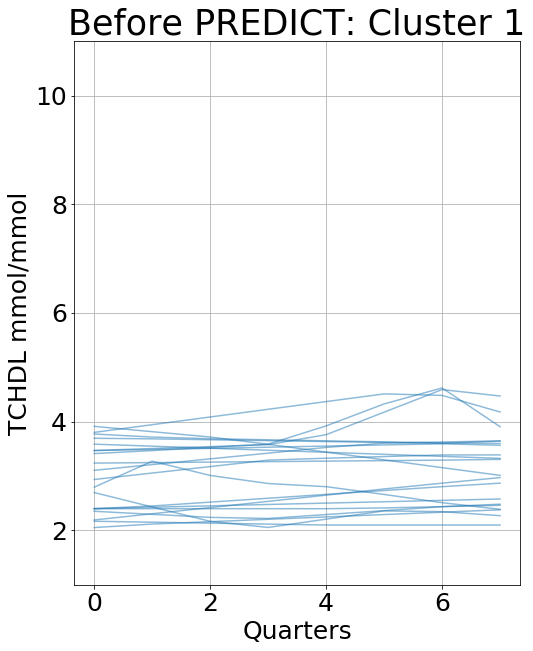

In [149]:

# fig, axes = pyplot.subplots(5, 1)
for c in range(10):
    VIEW_clusters = VIEW_sub_v[VIEW_sub_v[:, -1] == c]
    print("SIZE of Cluster " + str(c+1) + ": " + str(VIEW_clusters.shape[0]//28))


cluster_no = 0
fig = pyplot.figure(figsize=(8, 10))
#fig = pyplot.figure(figsize=(25, 10))
VIEW_clusters = VIEW_sub_v[VIEW_sub_v[:, -1] == cluster_no]
VIEW_clusters_b = VIEW_clusters[VIEW_clusters[:, 2] < 8]
VIEW_clusters_a = VIEW_clusters[VIEW_clusters[:, 2] >= 8]
print(VIEW_clusters_b.shape)
print(VIEW_clusters_a.shape)
print("SIZE of Cluster " + str(cluster_no+1) + ": " + str(VIEW_clusters.shape[0]//28))

for i in range(20):
    quarters = VIEW_clusters_b[(i*8):((i+1)*8), 2]
    TCHDL = VIEW_clusters_b[(i*8):((i+1)*8), 12]
    #quarters = VIEW_clusters_a[(i*20):((i+1)*20), 2]
    #TCHDL = VIEW_clusters_a[(i*20):((i+1)*20), 12]
    pyplot.plot(quarters, TCHDL, '-', color='C0', alpha=0.5, label="y")

pyplot.grid()
pyplot.tick_params(axis='both', which='major', labelsize=25)
pyplot.ylim([1, 11])
pyplot.title("Before PREDICT: Cluster " + str(cluster_no+1), fontsize=35)
#pyplot.title("DTW Agglomerative Clustering of TCHDL time-series: Cluster " + str(cluster_no+1), fontsize=35)
pyplot.xlabel("Quarters", fontsize=25)
pyplot.ylabel("TCHDL mmol/mmol", fontsize=25)
fig_name = '/home/whsu014/plots/VIEWb10ClustersCluster' + str(cluster_no+1) + 'max20samples.pdf'
fig.savefig(fig_name, bbox_inches='tight')
pyplot.show()
